Preprocessing feedback...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training sentiment analysis model...
Model Accuracy: 0.47

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.25      0.36         8
     neutral       1.00      0.50      0.67         2
    positive       0.36      0.80      0.50         5

    accuracy                           0.47        15
   macro avg       0.68      0.52      0.51        15
weighted avg       0.61      0.47      0.45        15


Sample Predictions:
Text: I hate this product! Will definitely buy again. (sarcasm)
Predicted sentiment: positive (confidence: 0.43)

Text: The quality is not what I expected. Really disappointed and won’t recommend it.
Predicted sentiment: positive (confidence: 0.46)

Text: It's okay, works as expected. Nothing great, nothing terrible.
Predicted sentiment: positive (confidence: 0.38)

Text: Absolutely thrilled with this purchase! I use it every day and it hasn’t let me down.
Predicted sentiment: positive (confidence: 0.59)

Text:

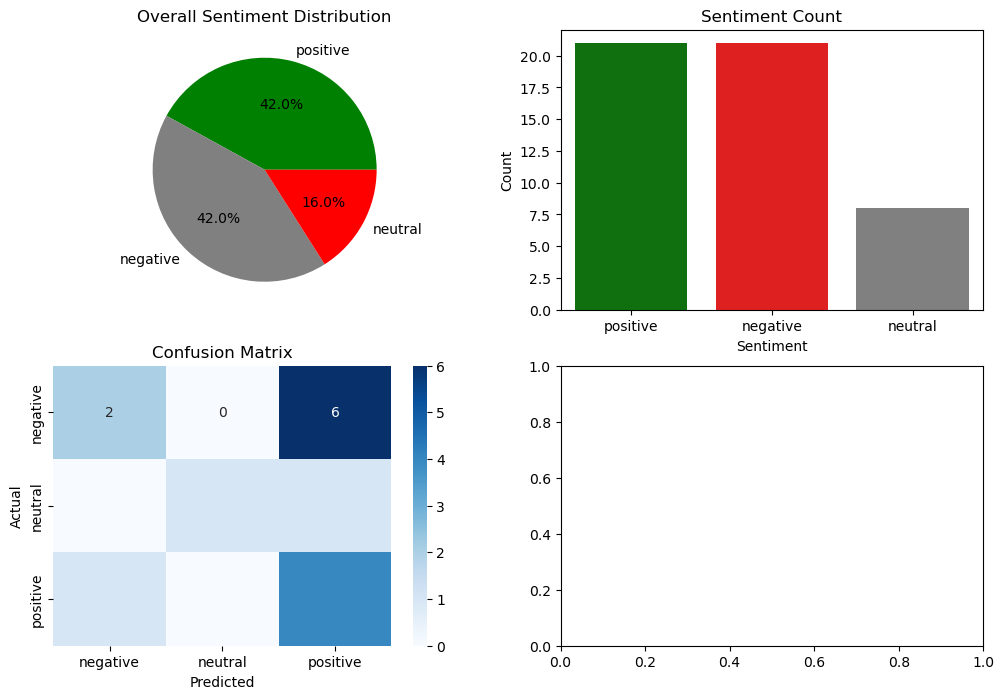

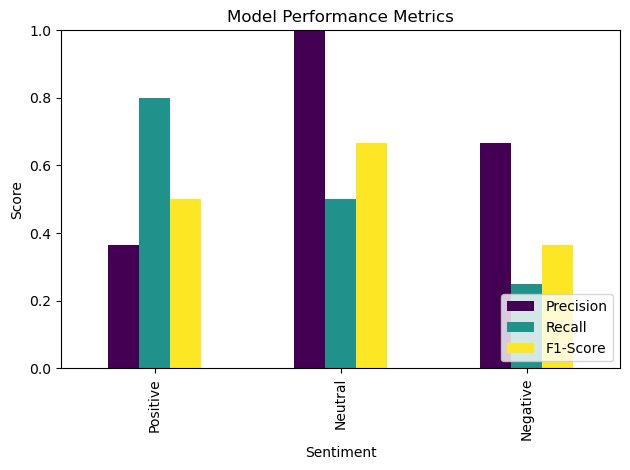

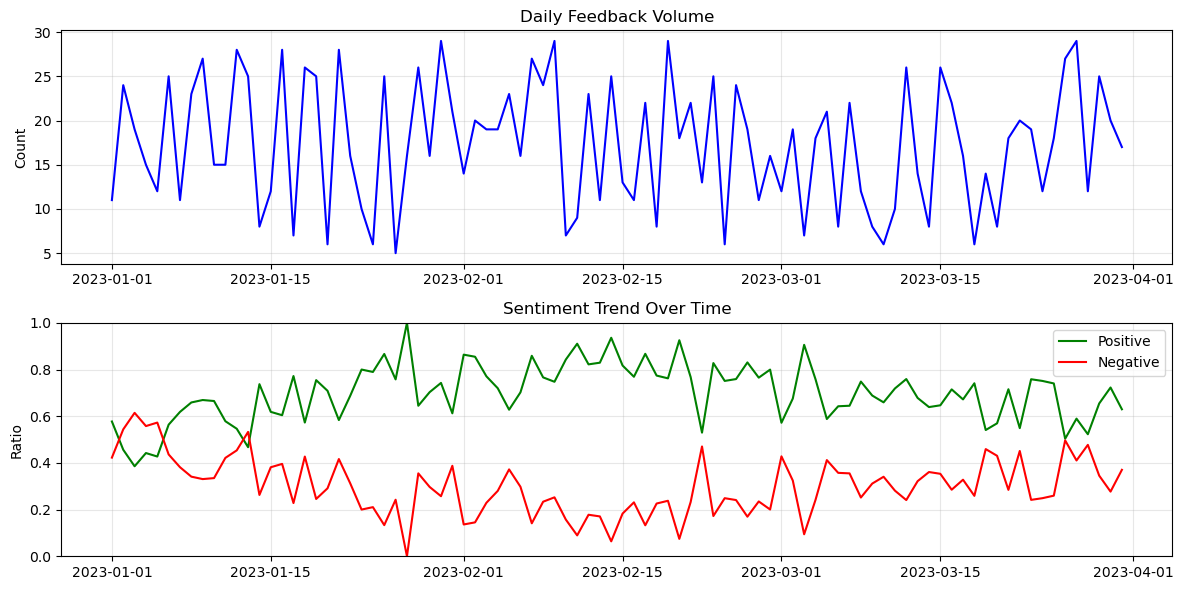

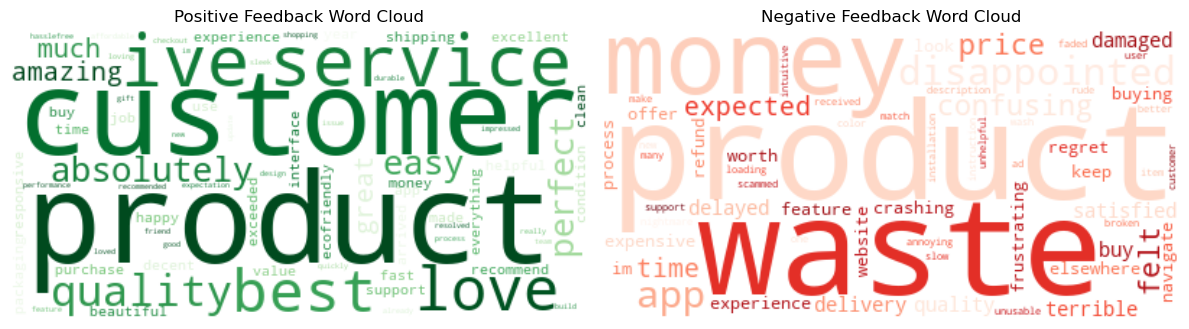

Sentiment analysis and visualization complete!


In [4]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
import re
import warnings
warnings.filterwarnings('ignore')


def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet']
    for resource in resources:
        try:
            print(f"Downloading {resource}...")
            nltk.download(resource, quiet=False)
        except Exception as e:
            print(f"Error downloading {resource}: {e}")
            
download_nltk_resources()

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

df = pd.read_csv('feedback.csv')

# Convert to dictionary (if needed)
data = {
    'feedback': df['feedback'].tolist(),
    'sentiment': df['sentiment'].tolist()
}

df = pd.DataFrame(data)

def preprocess_text(text):
    try:
        text = text.lower()
        
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        try:
            tokens = word_tokenize(text)
        except LookupError:
            tokens = text.split()
        
        try:
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
        except LookupError:
            pass
        
        try:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
        except LookupError:
            pass
        
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return text 

print("Preprocessing feedback...")
df['processed_feedback'] = df['feedback'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_feedback'], 
    df['sentiment'], 
    test_size=0.3, 
    random_state=42
)

print("Training sentiment analysis model...")
sentiment_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

sentiment_pipeline.fit(X_train, y_train)

y_pred = sentiment_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

def predict_sentiment(text):
    processed = preprocess_text(text)
    prediction = sentiment_pipeline.predict([processed])[0]
    probabilities = sentiment_pipeline.predict_proba([processed])[0]
    confidence = max(probabilities)
    return prediction, confidence

sample_texts = [
    "I hate this product! Will definitely buy again. (sarcasm)",
    "The quality is not what I expected. Really disappointed and won’t recommend it.",
    "It's okay, works as expected. Nothing great, nothing terrible.",
    "Absolutely thrilled with this purchase! I use it every day and it hasn’t let me down.",
    "Terrible product. Broke within a week and the company refused to refund me.",
    "I had my doubts at first, but this product really surprised me—in a good way!",
    "Meh. It does the job but don't expect too much.",
    "Customer service was very helpful and resolved my issue within minutes.",
    "It’s overpriced and underperforms. Definitely not worth the hype.",
    "I love the packaging and design, but the actual product didn’t live up to my expectations.",
    "Wow! This actually made my life easier. Super happy with the purchase.",
    "I’ve had better. It’s usable, but I won’t be buying it again.",
    "What a scam! Totally not what was advertised.",
    "Worked like a charm. Installation was simple and results were excellent.",
    "The app is a total mess—lags, bugs, and crashes constantly.",
    "Fast delivery, decent performance, and good customer support.",
    "Didn't love it, didn’t hate it. Just a standard experience.",
    "They sent the wrong item, and now I’m stuck with it. Extremely frustrating.",
    "Quality seems fine, but let’s see how it holds up over time.",
    "Not bad at all. In fact, I’m thinking of buying another one."
]

print("\nSample Predictions:")
for text in sample_texts:
    sentiment, confidence = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")
    print()

sentiment_counts = df['sentiment'].value_counts()

print("Creating visualizations...")
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'gray', 'red'])
plt.title('Overall Sentiment Distribution')

plt.subplot(2, 2, 2)
sns.countplot(x='sentiment', data=df, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sentiment_pipeline.classes_, 
            yticklabels=sentiment_pipeline.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 2, 4)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame({
    'Precision': [report_dict[c]['precision'] for c in ['positive', 'neutral', 'negative']],
    'Recall': [report_dict[c]['recall'] for c in ['positive', 'neutral', 'negative']],
    'F1-Score': [report_dict[c]['f1-score'] for c in ['positive', 'neutral', 'negative']]
}, index=['Positive', 'Neutral', 'Negative'])
report_df.plot(kind='bar', colormap='viridis')
plt.title('Model Performance Metrics')
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('sentiment_analysis_results.png')
plt.show()

try:
    np.random.seed(42)
    dates = pd.date_range(start='2023-01-01', periods=90, freq='D')
    daily_feedback_count = np.random.randint(5, 30, size=90)
    positive_ratio = 0.5 + 0.3 * np.sin(np.linspace(0, 3, 90)) + np.random.normal(0, 0.1, 90)
    positive_ratio = np.clip(positive_ratio, 0, 1)

    time_df = pd.DataFrame({
        'date': dates,
        'feedback_count': daily_feedback_count,
        'positive_ratio': positive_ratio,
        'negative_ratio': 1 - positive_ratio
    })

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time_df['date'], time_df['feedback_count'], 'b-')
    plt.title('Daily Feedback Volume')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(time_df['date'], time_df['positive_ratio'], 'g-', label='Positive')
    plt.plot(time_df['date'], time_df['negative_ratio'], 'r-', label='Negative')
    plt.title('Sentiment Trend Over Time')
    plt.ylabel('Ratio')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('sentiment_trend_analysis.png')
    plt.show()
except Exception as e:
    print(f"Skipping time series visualization due to error: {e}")

try:
    from wordcloud import WordCloud
    
    # Join all positive and negative feedback
    positive_text = ' '.join(df[df['sentiment'] == 'positive']['processed_feedback'])
    negative_text = ' '.join(df[df['sentiment'] == 'negative']['processed_feedback'])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    if positive_text.strip():
        wordcloud_positive = WordCloud(width=400, height=200, background_color='white', max_words=100, colormap='Greens').generate(positive_text)
        plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Positive Feedback Word Cloud')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if negative_text.strip():
        wordcloud_negative = WordCloud(width=400, height=200, background_color='white', max_words=100, colormap='Reds').generate(negative_text)
        plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Negative Feedback Word Cloud')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('sentiment_wordclouds.png')
    plt.show()
except ImportError:
    print("WordCloud package not available. Skipping word cloud visualization.")
except Exception as e:
    print(f"Error creating word clouds: {e}")

print("Sentiment analysis and visualization complete!")

Starting sentiment analysis on data from -f
Successfully loaded data from -f
Dataset shape: (20, 3)
Preprocessing feedback text...
Training data size: 14, Testing data size: 6
Training sentiment analysis model...
Model Accuracy: 0.50

Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.50      0.57         4
     neutral       0.00      0.00      0.00         0
    positive       0.50      0.50      0.50         2

    accuracy                           0.50         6
   macro avg       0.39      0.33      0.36         6
weighted avg       0.61      0.50      0.55         6


Sample Predictions:
Text: I absolutely love this product! Will definitely buy again.
Predicted sentiment: positive (confidence: 0.47)

Text: The quality is not what I expected. Disappointed.
Predicted sentiment: positive (confidence: 0.45)

Text: It's okay, works as expected.
Predicted sentiment: neutral (confidence: 0.35)

Creating visualizations...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Basic visualizations saved to 'sentiment_analysis_results.png'
Time series visualization saved to 'sentiment_trend_analysis.png'
Word clouds saved to 'sentiment_wordclouds.png'


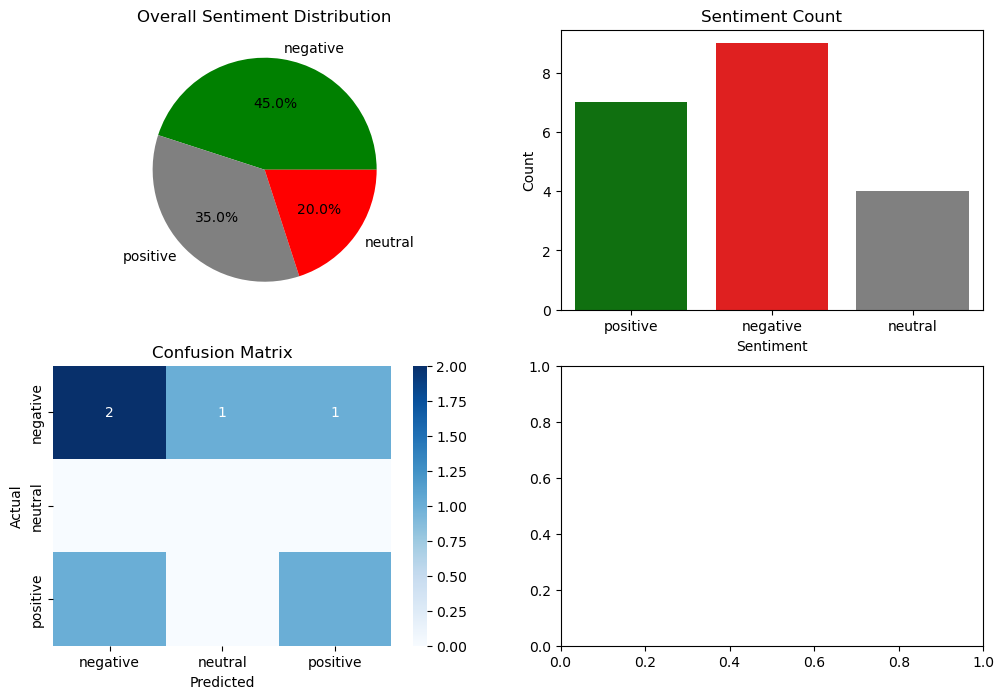

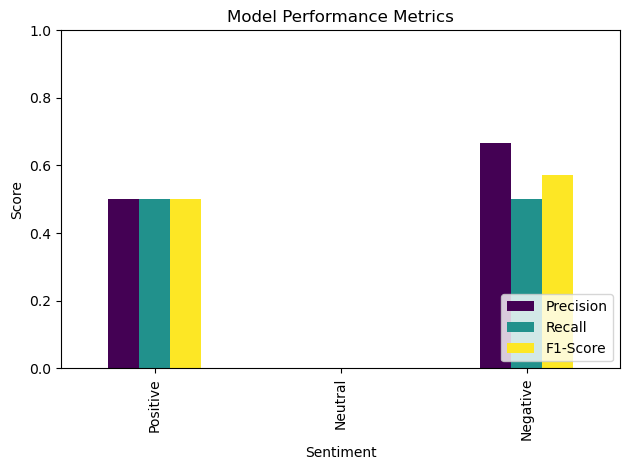

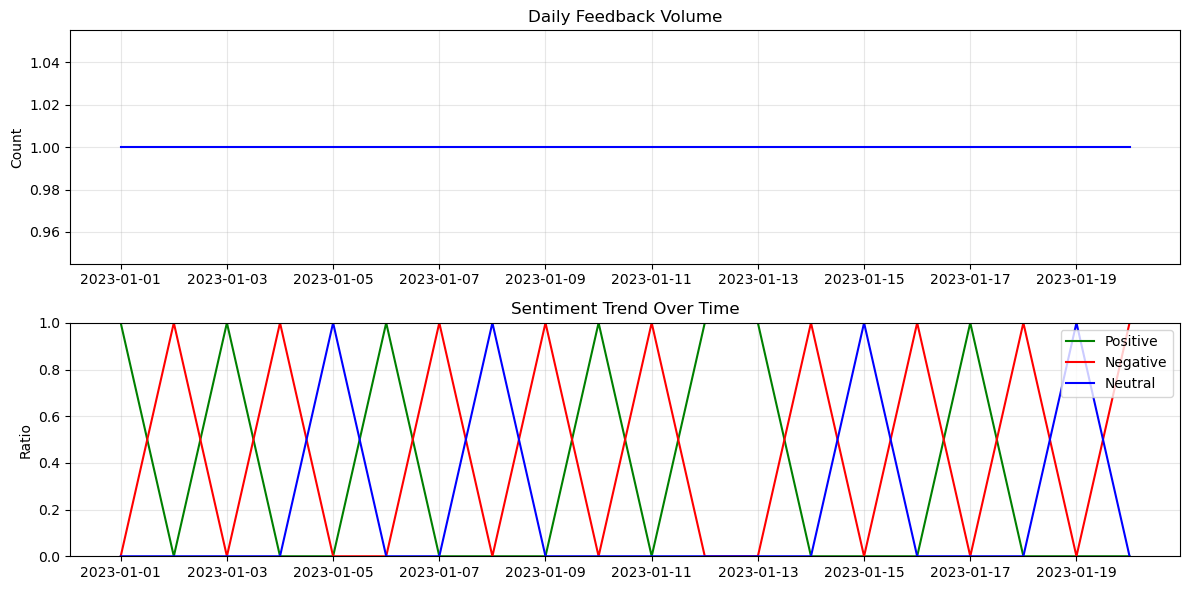

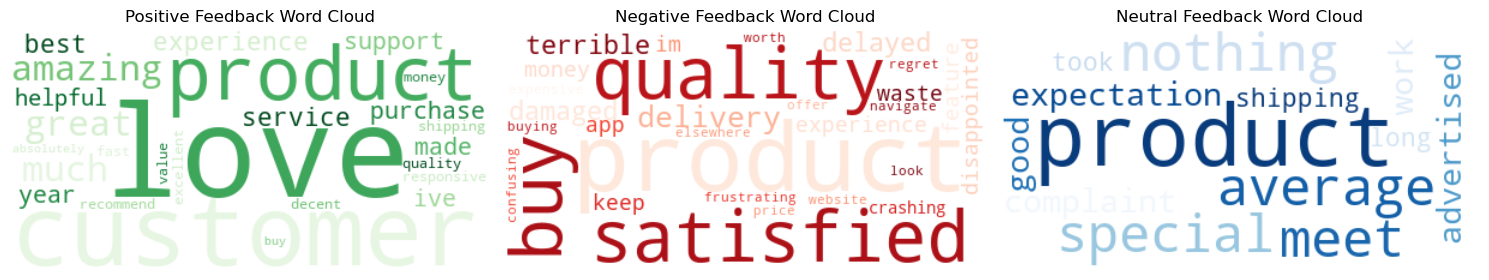


Analysis complete!
The model is now available as 'model' and the processed data as 'data'
You can use model.predict(new_text) to classify new feedback


In [7]:
# Sentiment Analysis for Customer Feedback
# This script loads data from a CSV file, performs sentiment analysis, and visualizes the results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
import re
import os
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet']
    for resource in resources:
        try:
            print(f"Downloading {resource}...")
            nltk.download(resource, quiet=False)
        except Exception as e:
            print(f"Error downloading {resource}: {e}")
            
# Call the function to download resources
download_nltk_resources()

# Import NLTK modules after downloading resources
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Function to load data from CSV file
def load_data_from_csv(file_path):
    """
    Load customer feedback data from a CSV file.
    Expected CSV format:
    - Must contain 'feedback' column with text
    - Must contain 'sentiment' column with labels ('positive', 'negative', 'neutral')
    - Can contain additional columns that will be preserved
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return create_sample_csv(file_path)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Check required columns
        required_columns = ['feedback', 'sentiment']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"CSV file is missing required columns: {missing_columns}")
            return create_sample_csv(file_path)
        
        # Validate sentiment labels
        valid_sentiments = ['positive', 'negative', 'neutral']
        invalid_sentiments = df[~df['sentiment'].isin(valid_sentiments)]['sentiment'].unique()
        
        if len(invalid_sentiments) > 0:
            print(f"Warning: Found invalid sentiment labels: {invalid_sentiments}")
            print("Converting invalid sentiments to 'neutral'")
            df.loc[~df['sentiment'].isin(valid_sentiments), 'sentiment'] = 'neutral'
        
        print(f"Successfully loaded data from {file_path}")
        print(f"Dataset shape: {df.shape}")
        
        return df
    
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return create_sample_csv(file_path)

# Function to create a sample CSV if the file doesn't exist or has issues
def create_sample_csv(file_path):
    print("Creating sample data file for demonstration...")
    
    # Sample data with customer feedback
    data = {
        'feedback': [
            "The product is amazing! I love it so much.",
            "Not satisfied with the quality, will not buy again.",
            "I had a great experience with customer service.",
            "Delivery was delayed and the product was damaged.",
            "Average product, nothing special about it.",
            "This is the best purchase I've made all year!",
            "Terrible experience, waste of money.",
            "The product meets my expectations.",
            "I'm disappointed with the features.",
            "Customer support was helpful and responsive.",
            "The app keeps crashing, very frustrating.",
            "Decent value for money, would recommend.",
            "Excellent quality and fast shipping!",
            "Too expensive for what it offers.",
            "Product works as advertised, no complaints.",
            "I regret buying this product.",
            "Absolutely love it! Will buy again.",
            "The website was confusing to navigate.",
            "Good product but shipping took too long.",
            "Not worth the price, look elsewhere."
        ],
        'sentiment': [
            'positive', 'negative', 'positive', 'negative', 'neutral',
            'positive', 'negative', 'neutral', 'negative', 'positive',
            'negative', 'positive', 'positive', 'negative', 'neutral',
            'negative', 'positive', 'negative', 'neutral', 'negative'
        ],
        'date': pd.date_range(start='2023-01-01', periods=20).astype(str)
    }
    
    sample_df = pd.DataFrame(data)
    
    # Save to CSV
    try:
        sample_df.to_csv(file_path, index=False)
        print(f"Sample data saved to {file_path}")
    except Exception as e:
        print(f"Error saving sample data: {e}")
        print("Using sample data in memory instead.")
    
    return sample_df

# Text preprocessing function with error handling
def preprocess_text(text):
    try:
        # Handle NaN values
        if pd.isna(text):
            return ""
            
        # Convert to string if not already
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters, numbers, and extra whitespace
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Tokenize the text
        try:
            tokens = word_tokenize(text)
        except LookupError:
            # Fallback tokenization if NLTK resources aren't available
            tokens = text.split()
        
        # Remove stopwords with error handling
        try:
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
        except LookupError:
            # If stopwords aren't available, just continue
            pass
        
        # Lemmatize with error handling
        try:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
        except LookupError:
            # If wordnet isn't available, just continue
            pass
        
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return ""  # Return empty string if preprocessing fails

# Main function to run the sentiment analysis pipeline
def analyze_sentiment(csv_file_path="customer_feedback.csv"):
    """
    Run the complete sentiment analysis pipeline:
    1. Load data from CSV
    2. Preprocess text
    3. Build and train the model
    4. Evaluate performance
    5. Create visualizations
    """
    print(f"Starting sentiment analysis on data from {csv_file_path}")
    
    # Load data from CSV
    df = load_data_from_csv(csv_file_path)
    
    # Apply preprocessing to the feedback
    print("Preprocessing feedback text...")
    df['processed_feedback'] = df['feedback'].apply(preprocess_text)
    
    # Check for empty strings after preprocessing
    empty_count = df['processed_feedback'].str.strip().eq('').sum()
    if empty_count > 0:
        print(f"Warning: {empty_count} entries became empty after preprocessing")
        # Fill empty strings with original text to avoid model issues
        mask = df['processed_feedback'].str.strip().eq('')
        df.loc[mask, 'processed_feedback'] = df.loc[mask, 'feedback']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        df['processed_feedback'], 
        df['sentiment'], 
        test_size=0.3, 
        random_state=42
    )
    
    print(f"Training data size: {X_train.shape[0]}, Testing data size: {X_test.shape[0]}")
    
    # Create a pipeline with TF-IDF vectorizer and Logistic Regression
    print("Training sentiment analysis model...")
    sentiment_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Train the model
    sentiment_pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = sentiment_pipeline.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(report)
    
    # Function to predict sentiment of new feedback
    def predict_sentiment(text):
        processed = preprocess_text(text)
        if not processed.strip():  # Handle empty text
            return "neutral", 1.0
        prediction = sentiment_pipeline.predict([processed])[0]
        probabilities = sentiment_pipeline.predict_proba([processed])[0]
        confidence = max(probabilities)
        return prediction, confidence
    
    # Sample predictions
    print("\nSample Predictions:")
    sample_texts = [
        "I absolutely love this product! Will definitely buy again.",
        "The quality is not what I expected. Disappointed.",
        "It's okay, works as expected."
    ]
    
    for text in sample_texts:
        sentiment, confidence = predict_sentiment(text)
        print(f"Text: {text}")
        print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2f})")
        print()
    
    # Calculate overall sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    
    # Create visualizations
    print("Creating visualizations...")
    create_visualizations(df, sentiment_counts, y_test, y_pred, conf_matrix, sentiment_pipeline)
    
    # Return the model and processed dataframe for further use
    return sentiment_pipeline, df

def create_visualizations(df, sentiment_counts, y_test, y_pred, conf_matrix, sentiment_pipeline):
    """Create and save all visualizations"""
    
    # Create basic visualizations
    plt.figure(figsize=(12, 8))
    
    # 1. Sentiment Distribution Pie Chart
    plt.subplot(2, 2, 1)
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
            colors=['green', 'gray', 'red'])
    plt.title('Overall Sentiment Distribution')
    
    # 2. Sentiment Distribution Bar Chart
    plt.subplot(2, 2, 2)
    sns.countplot(x='sentiment', data=df, palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
    plt.title('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    
    # 3. Confusion Matrix Heatmap
    plt.subplot(2, 2, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sentiment_pipeline.classes_, 
                yticklabels=sentiment_pipeline.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 4. Model Performance Metrics
    plt.subplot(2, 2, 4)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame({
        'Precision': [report_dict[c]['precision'] for c in ['positive', 'neutral', 'negative']],
        'Recall': [report_dict[c]['recall'] for c in ['positive', 'neutral', 'negative']],
        'F1-Score': [report_dict[c]['f1-score'] for c in ['positive', 'neutral', 'negative']]
    }, index=['Positive', 'Neutral', 'Negative'])
    report_df.plot(kind='bar', colormap='viridis')
    plt.title('Model Performance Metrics')
    plt.xlabel('Sentiment')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('sentiment_analysis_results.png')
    print("Basic visualizations saved to 'sentiment_analysis_results.png'")
    
    # Create time series visualization if date column exists
    try:
        if 'date' in df.columns:
            create_time_series_visualizations(df)
        else:
            print("No date column found. Skipping time series visualization.")
    except Exception as e:
        print(f"Error creating time series visualization: {e}")
    
    # Create word clouds
    try:
        create_wordclouds(df)
    except Exception as e:
        print(f"Error creating word clouds: {e}")
    
    plt.show()

def create_time_series_visualizations(df):
    """Create time series visualizations if date data is available"""
    try:
        # Convert date column to datetime if it's not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Group by date and count feedback
        time_df = df.groupby('date').size().reset_index(name='count')
        
        # Calculate sentiment ratios over time
        sentiment_over_time = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
        total = sentiment_over_time.sum(axis=1)
        
        # Calculate ratios (handle div by zero)
        for col in sentiment_over_time.columns:
            sentiment_over_time[f'{col}_ratio'] = sentiment_over_time[col] / total.replace(0, 1)
        
        # Plot time series
        plt.figure(figsize=(12, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(time_df['date'], time_df['count'], 'b-')
        plt.title('Daily Feedback Volume')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        if 'positive' in sentiment_over_time.columns:
            plt.plot(sentiment_over_time.index, sentiment_over_time['positive_ratio'], 'g-', label='Positive')
        if 'negative' in sentiment_over_time.columns:
            plt.plot(sentiment_over_time.index, sentiment_over_time['negative_ratio'], 'r-', label='Negative')
        if 'neutral' in sentiment_over_time.columns:
            plt.plot(sentiment_over_time.index, sentiment_over_time['neutral_ratio'], 'b-', label='Neutral')
            
        plt.title('Sentiment Trend Over Time')
        plt.ylabel('Ratio')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('sentiment_trend_analysis.png')
        print("Time series visualization saved to 'sentiment_trend_analysis.png'")
        
    except Exception as e:
        print(f"Error in time series visualization: {e}")
        # If real date processing fails, create simulated data
        print("Creating simulated time series data instead")
        
        # Simulate time series data
        np.random.seed(42)
        dates = pd.date_range(start='2023-01-01', periods=90, freq='D')
        daily_feedback_count = np.random.randint(5, 30, size=90)
        positive_ratio = 0.5 + 0.3 * np.sin(np.linspace(0, 3, 90)) + np.random.normal(0, 0.1, 90)
        positive_ratio = np.clip(positive_ratio, 0, 1)

        time_df = pd.DataFrame({
            'date': dates,
            'feedback_count': daily_feedback_count,
            'positive_ratio': positive_ratio,
            'negative_ratio': 1 - positive_ratio
        })

        # Time series visualization
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.plot(time_df['date'], time_df['feedback_count'], 'b-')
        plt.title('Daily Feedback Volume (Simulated)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 1, 2)
        plt.plot(time_df['date'], time_df['positive_ratio'], 'g-', label='Positive')
        plt.plot(time_df['date'], time_df['negative_ratio'], 'r-', label='Negative')
        plt.title('Sentiment Trend Over Time (Simulated)')
        plt.ylabel('Ratio')
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.legend()

        plt.tight_layout()
        plt.savefig('sentiment_trend_analysis_simulated.png')
        print("Simulated time series visualization saved to 'sentiment_trend_analysis_simulated.png'")

def create_wordclouds(df):
    """Create word clouds for different sentiment categories"""
    try:
        from wordcloud import WordCloud
        
        # Join all feedback by sentiment category
        sentiment_text = {}
        for sentiment in ['positive', 'negative', 'neutral']:
            if sentiment in df['sentiment'].unique():
                sentiment_text[sentiment] = ' '.join(
                    df[df['sentiment'] == sentiment]['processed_feedback'].fillna('').astype(str)
                )
        
        # Calculate number of subplots needed
        n_sentiments = len(sentiment_text)
        if n_sentiments == 0:
            print("No sentiment data available for word clouds")
            return
            
        plt.figure(figsize=(15, 5))
        
        # Colors for different sentiments
        colors = {'positive': 'Greens', 'negative': 'Reds', 'neutral': 'Blues'}
        
        # Create word cloud for each sentiment
        for i, (sentiment, text) in enumerate(sentiment_text.items(), 1):
            plt.subplot(1, n_sentiments, i)
            if text.strip():
                wordcloud = WordCloud(
                    width=400, 
                    height=200, 
                    background_color='white', 
                    max_words=100, 
                    colormap=colors.get(sentiment, 'viridis')
                ).generate(text)
                plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'{sentiment.capitalize()} Feedback Word Cloud')
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('sentiment_wordclouds.png')
        print("Word clouds saved to 'sentiment_wordclouds.png'")
        
    except ImportError:
        print("WordCloud package not available. Install with: pip install wordcloud")
    except Exception as e:
        print(f"Error creating word clouds: {e}")

if __name__ == "__main__":
    # If run directly, ask for the CSV file path
    import sys
    
    if len(sys.argv) > 1:
        csv_path = sys.argv[1]
    else:
        csv_path = input("Enter path to CSV file (or press Enter for default 'customer_feedback.csv'): ").strip()
        if not csv_path:
            csv_path = "feedback.csv"
    
    # Run the analysis
    model, data = analyze_sentiment(csv_path)
    
    print("\nAnalysis complete!")
    print("The model is now available as 'model' and the processed data as 'data'")
    print("You can use model.predict(new_text) to classify new feedback")